In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights,resnet18, ResNet18_Weights
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device



'cuda'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Linear Tunning of ResNet50##

##ResNet50 Parameters##

In [3]:
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
params = count_parameters(model)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|         conv1.weight         |    9408    |
|          bn1.weight          |     64     |
|           bn1.bias           |     64     |
|    layer1.0.conv1.weight     |    4096    |
|     layer1.0.bn1.weight      |     64     |
|      layer1.0.bn1.bias       |     64     |
|    layer1.0.conv2.weight     |   36864    |
|     layer1.0.bn2.weight      |     64     |
|      layer1.0.bn2.bias       |     64     |
|    layer1.0.conv3.weight     |   16384    |
|     layer1.0.bn3.weight      |    256     |
|      layer1.0.bn3.bias       |    256     |
| layer1.0.downsample.0.weight |   16384    |
| layer1.0.downsample.1.weight |    256     |
|  layer1.0.downsample.1.bias  |    256     |
|    layer1.1.conv1.weight     |   16384    |
|     layer1.1.bn1.weight      |     64     |
|      layer1.1.bn1.bias       |     64     |
|    layer1.1.conv2.weight     |  

##Freeze ResNet50 Parameters Except Last Layer##

In [4]:
for name, parameter in model.named_parameters():
  if name =='fc.weight' or name =='fc.bias':
    continue
  parameter.requires_grad = False
for name, layer in model.named_modules():
    if name =='fc':
        model._modules[name] = torch.nn.Linear(2048, 10)

In [5]:
params = count_parameters(model)

+-----------+------------+
|  Modules  | Parameters |
+-----------+------------+
| fc.weight |   20480    |
|  fc.bias  |     10     |
+-----------+------------+
Total Trainable Params: 20490


##Get Random Image from Each Class of CIFAR10##

In [6]:
transform = transforms.Compose(
    [transforms.Resize(224),transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

training_data = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)


test_data = datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


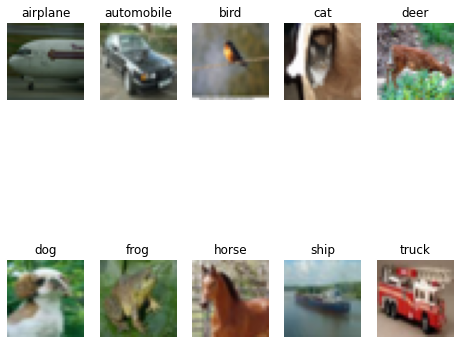

In [7]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 2
for i in range(10):
    training_data_i = torch.from_numpy(training_data.data)[torch.from_numpy(np.asarray(training_data.targets))==i]
    img = training_data_i[torch.randint(0, len(training_data_i), (1, )).item()]
    figure.add_subplot(rows, cols, i+1)
    plt.title(training_data.classes[i])
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

In [8]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        model.train()
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            model.eval()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [9]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

In [10]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
epochs = 5
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
test_accuracy = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_accuracy.append(test_loop(test_dataloader, model, loss_fn))
    if t>0:
       if test_accuracy[t-1]<=test_accuracy[t]:
         torch.save(model, '/content/drive/MyDrive/HW3/ResNet50_Model_CIFAR10_Dataset.pth')
      
print("Done!")

Epoch 1
-------------------------------
loss: 2.339493  [    0/50000]
loss: 1.039047  [ 6400/50000]
loss: 0.856397  [12800/50000]
loss: 0.767105  [19200/50000]
loss: 0.919997  [25600/50000]
loss: 0.900251  [32000/50000]
loss: 0.665935  [38400/50000]
loss: 0.697197  [44800/50000]
Test Error: 
 Accuracy: 79.3%, Avg loss: 0.626318 

Epoch 2
-------------------------------
loss: 0.661106  [    0/50000]
loss: 0.503313  [ 6400/50000]
loss: 0.555529  [12800/50000]
loss: 0.699245  [19200/50000]
loss: 0.694203  [25600/50000]
loss: 0.391170  [32000/50000]
loss: 0.470740  [38400/50000]
loss: 0.578614  [44800/50000]
Test Error: 
 Accuracy: 80.4%, Avg loss: 0.577239 

Epoch 3
-------------------------------
loss: 0.300077  [    0/50000]
loss: 0.720946  [ 6400/50000]
loss: 0.478494  [12800/50000]
loss: 0.677043  [19200/50000]
loss: 0.528316  [25600/50000]
loss: 0.553079  [32000/50000]
loss: 0.415711  [38400/50000]
loss: 0.437474  [44800/50000]
Test Error: 
 Accuracy: 81.3%, Avg loss: 0.544012 

Epoc

##Training ResNet18(Strudent) with ResNet50(Teacher)##

In [11]:
weights1 = ResNet18_Weights.DEFAULT
model1 = resnet18(weights=weights1)
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
params1 = count_parameters(model1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|         conv1.weight         |    9408    |
|          bn1.weight          |     64     |
|           bn1.bias           |     64     |
|    layer1.0.conv1.weight     |   36864    |
|     layer1.0.bn1.weight      |     64     |
|      layer1.0.bn1.bias       |     64     |
|    layer1.0.conv2.weight     |   36864    |
|     layer1.0.bn2.weight      |     64     |
|      layer1.0.bn2.bias       |     64     |
|    layer1.1.conv1.weight     |   36864    |
|     layer1.1.bn1.weight      |     64     |
|      layer1.1.bn1.bias       |     64     |
|    layer1.1.conv2.weight     |   36864    |
|     layer1.1.bn2.weight      |     64     |
|      layer1.1.bn2.bias       |     64     |
|    layer2.0.conv1.weight     |   73728    |
|     layer2.0.bn1.weight      |    128     |
|      layer2.0.bn1.bias       |    128     |
|    layer2.0.conv2.weight     |  

In [12]:
for name, layer in model1.named_modules():
    if name =='fc':
        model1._modules[name] = torch.nn.Linear(512, 10)

In [13]:
params1 = count_parameters(model1)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|         conv1.weight         |    9408    |
|          bn1.weight          |     64     |
|           bn1.bias           |     64     |
|    layer1.0.conv1.weight     |   36864    |
|     layer1.0.bn1.weight      |     64     |
|      layer1.0.bn1.bias       |     64     |
|    layer1.0.conv2.weight     |   36864    |
|     layer1.0.bn2.weight      |     64     |
|      layer1.0.bn2.bias       |     64     |
|    layer1.1.conv1.weight     |   36864    |
|     layer1.1.bn1.weight      |     64     |
|      layer1.1.bn1.bias       |     64     |
|    layer1.1.conv2.weight     |   36864    |
|     layer1.1.bn2.weight      |     64     |
|      layer1.1.bn2.bias       |     64     |
|    layer2.0.conv1.weight     |   73728    |
|     layer2.0.bn1.weight      |    128     |
|      layer2.0.bn1.bias       |    128     |
|    layer2.0.conv2.weight     |  

##Finding The Best Distillation Hyperparameters in 2 epochs##

In [14]:
def distillation_train_loop(dataloader,model1,model,alpha,temp, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        with torch.no_grad():
            model.eval()
            pred = model(X)
        model1.train()
        pred1 = model1(X)
        loss = (1-alpha)*loss_fn(pred1, y) + (alpha)*loss_fn(pred1/temp,torch.exp(F.log_softmax(pred/temp,dim=1)))
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [15]:
import copy
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
epochs = 2
model1.to(device)
teacher_model = torch.load('/content/drive/MyDrive/HW3/ResNet50_Model_CIFAR10_Dataset.pth')
teacher_model.to(device)
test_accuracy1 = []
alphas =[0.5,0.8,1]
temps =[1,10,20]
for alpha in alphas:
  for temp in temps:
      student_model = copy.deepcopy(model1)
      optimizer = torch.optim.Adam(student_model.parameters(), lr=learning_rate)
      for t in range(epochs):
          print(f"Epoch {t+1}\n-------------------------------")
          distillation_train_loop(train_dataloader,student_model,teacher_model,alpha,temp,loss_fn, optimizer)
          test_accuracy1.append(test_loop(test_dataloader,student_model, loss_fn))
          if np.argmax(test_accuracy1)==len(test_accuracy1)-1:
              main_alpha = alpha
              main_temp = temp
              torch.save(student_model,'/content/drive/MyDrive/HW3/ResNet18_Distillation_Model_CIFAR10_Dataset.pth')
            
      print("Done!")

Epoch 1
-------------------------------
loss: 2.607033  [    0/50000]
loss: 0.855060  [ 6400/50000]
loss: 0.721357  [12800/50000]
loss: 0.825905  [19200/50000]
loss: 0.530670  [25600/50000]
loss: 0.831626  [32000/50000]
loss: 0.653295  [38400/50000]
loss: 0.718187  [44800/50000]
Test Error: 
 Accuracy: 86.5%, Avg loss: 0.432862 

Epoch 2
-------------------------------
loss: 0.649047  [    0/50000]
loss: 0.562082  [ 6400/50000]
loss: 0.729087  [12800/50000]
loss: 0.572182  [19200/50000]
loss: 0.536061  [25600/50000]
loss: 0.617897  [32000/50000]
loss: 0.572347  [38400/50000]
loss: 0.505162  [44800/50000]
Test Error: 
 Accuracy: 89.5%, Avg loss: 0.359880 

Done!
Epoch 1
-------------------------------
loss: 2.435508  [    0/50000]
loss: 1.410447  [ 6400/50000]
loss: 1.538171  [12800/50000]
loss: 1.497241  [19200/50000]
loss: 1.416420  [25600/50000]
loss: 1.314050  [32000/50000]
loss: 1.351855  [38400/50000]
loss: 1.326334  [44800/50000]
Test Error: 
 Accuracy: 84.6%, Avg loss: 0.451061 

##The Best Distillation Hyperparameters##

In [16]:
print(f'The best alpha is:{main_alpha}')
print(f'The best temperture is:{main_temp}')

The best alpha is:0.5
The best temperture is:1


##Training Student Model With Best Hyperparameters in 5 Epochs ##

In [17]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
epochs =3
teacher_model = torch.load('/content/drive/MyDrive/HW3/ResNet50_Model_CIFAR10_Dataset.pth')
teacher_model.to(device)
test_accuracy1 = [np.max(test_accuracy1)]
student_model = torch.load('/content/drive/MyDrive/HW3/ResNet18_Distillation_Model_CIFAR10_Dataset.pth')
student_model.to(device)
optimizer = torch.optim.Adam(student_model.parameters(), lr=learning_rate)
for t in range(epochs):
          print(f"Epoch {t+3}\n-------------------------------")
          distillation_train_loop(train_dataloader,student_model,teacher_model,main_alpha ,main_temp,loss_fn, optimizer)
          test_accuracy1.append(test_loop(test_dataloader,student_model, loss_fn))
          if np.argmax(test_accuracy1)==len(test_accuracy1)-1:
              torch.save(student_model,'/content/drive/MyDrive/HW3/ResNet18_Distillation_Model_CIFAR10_Dataset.pth')   
print("Done!")

Epoch 3
-------------------------------
loss: 0.508868  [    0/50000]
loss: 0.685592  [ 6400/50000]
loss: 0.686525  [12800/50000]
loss: 0.635633  [19200/50000]
loss: 0.467405  [25600/50000]
loss: 0.582348  [32000/50000]
loss: 0.489647  [38400/50000]
loss: 0.655083  [44800/50000]
Test Error: 
 Accuracy: 88.5%, Avg loss: 0.383149 

Epoch 4
-------------------------------
loss: 0.536116  [    0/50000]
loss: 0.487661  [ 6400/50000]
loss: 0.516383  [12800/50000]
loss: 0.413175  [19200/50000]
loss: 0.394086  [25600/50000]
loss: 0.598788  [32000/50000]
loss: 0.410153  [38400/50000]
loss: 0.494124  [44800/50000]
Test Error: 
 Accuracy: 89.3%, Avg loss: 0.344811 

Epoch 5
-------------------------------
loss: 0.542951  [    0/50000]
loss: 0.551248  [ 6400/50000]
loss: 0.527896  [12800/50000]
loss: 0.333222  [19200/50000]
loss: 0.382470  [25600/50000]
loss: 0.459639  [32000/50000]
loss: 0.567631  [38400/50000]
loss: 0.603407  [44800/50000]
Test Error: 
 Accuracy: 90.4%, Avg loss: 0.325261 

Done

##Training ResNet18 On CIFAR10 Without Teacher##

In [18]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
epochs = 5
model1.to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)
test_accuracy2 = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model1, loss_fn, optimizer)
    test_accuracy2.append(test_loop(test_dataloader, model1, loss_fn))
    if t>0:
       if test_accuracy2[t-1]<=test_accuracy2[t]:
         torch.save(model1,'/content/drive/MyDrive/HW3/ResNet18_Model_CIFAR10_Dataset.pth')
      
print("Done!")

Epoch 1
-------------------------------
loss: 2.478205  [    0/50000]
loss: 0.749595  [ 6400/50000]
loss: 0.572359  [12800/50000]
loss: 0.504523  [19200/50000]
loss: 0.509772  [25600/50000]
loss: 0.429851  [32000/50000]
loss: 0.549138  [38400/50000]
loss: 0.414250  [44800/50000]
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.439722 

Epoch 2
-------------------------------
loss: 0.386600  [    0/50000]
loss: 0.187304  [ 6400/50000]
loss: 0.549811  [12800/50000]
loss: 0.248374  [19200/50000]
loss: 0.364170  [25600/50000]
loss: 0.273213  [32000/50000]
loss: 0.580098  [38400/50000]
loss: 0.291776  [44800/50000]
Test Error: 
 Accuracy: 88.2%, Avg loss: 0.348827 

Epoch 3
-------------------------------
loss: 0.149103  [    0/50000]
loss: 0.189486  [ 6400/50000]
loss: 0.280497  [12800/50000]
loss: 0.103397  [19200/50000]
loss: 0.237522  [25600/50000]
loss: 0.292543  [32000/50000]
loss: 0.113840  [38400/50000]
loss: 0.143865  [44800/50000]
Test Error: 
 Accuracy: 89.9%, Avg loss: 0.300335 

Epoc

##Comparison Results of Training ResNet18 With & Without Teacher:##
Accuracy of training with teacher(90.4%) is 0.5 percent better than training without teacher(89.9) after 5 epochs.<br>
Distillation makes the performance a litlle bit better.<br>
The reason that we didn't get signigiciant result with distllation based on the overview of the article(https://arxiv.org/abs/2106.05945) is:<br> "We show that while knowledge distillation can improve student generalization, it does not typically work as it is commonly understood: there often remains a surprisingly large discrepancy between the predictive distributions of the teacher and the student, even in cases when the student has the capacity to perfectly match the teacher.<br> 
We identify difficulties in optimization as a key reason for why the student is unable to match the teacher. We also show how the details of the dataset used for distillation play a role in how closely the student matches the teacher and that more closely matching the teacher paradoxically does not always lead to better student generalization." 

##Fine Tunning of ResNet50##

##ResNet50 Parameters##

In [19]:
weights2 = ResNet50_Weights.DEFAULT
model2 = resnet50(weights=weights2)
params2 = count_parameters(model2)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|         conv1.weight         |    9408    |
|          bn1.weight          |     64     |
|           bn1.bias           |     64     |
|    layer1.0.conv1.weight     |    4096    |
|     layer1.0.bn1.weight      |     64     |
|      layer1.0.bn1.bias       |     64     |
|    layer1.0.conv2.weight     |   36864    |
|     layer1.0.bn2.weight      |     64     |
|      layer1.0.bn2.bias       |     64     |
|    layer1.0.conv3.weight     |   16384    |
|     layer1.0.bn3.weight      |    256     |
|      layer1.0.bn3.bias       |    256     |
| layer1.0.downsample.0.weight |   16384    |
| layer1.0.downsample.1.weight |    256     |
|  layer1.0.downsample.1.bias  |    256     |
|    layer1.1.conv1.weight     |   16384    |
|     layer1.1.bn1.weight      |     64     |
|      layer1.1.bn1.bias       |     64     |
|    layer1.1.conv2.weight     |  

##Freeze First Few Layers of ResNet50 ##

In [20]:
for name, parameter in model2.named_parameters():
  if name =='layer2.0.conv1.weight':
    break
  parameter.requires_grad = False
for name, layer in model2.named_modules():
    if name =='fc':
        model2._modules[name] = torch.nn.Linear(2048, 10)

In [21]:
params2 = count_parameters(model2)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|    layer2.0.conv1.weight     |   32768    |
|     layer2.0.bn1.weight      |    128     |
|      layer2.0.bn1.bias       |    128     |
|    layer2.0.conv2.weight     |   147456   |
|     layer2.0.bn2.weight      |    128     |
|      layer2.0.bn2.bias       |    128     |
|    layer2.0.conv3.weight     |   65536    |
|     layer2.0.bn3.weight      |    512     |
|      layer2.0.bn3.bias       |    512     |
| layer2.0.downsample.0.weight |   131072   |
| layer2.0.downsample.1.weight |    512     |
|  layer2.0.downsample.1.bias  |    512     |
|    layer2.1.conv1.weight     |   65536    |
|     layer2.1.bn1.weight      |    128     |
|      layer2.1.bn1.bias       |    128     |
|    layer2.1.conv2.weight     |   147456   |
|     layer2.1.bn2.weight      |    128     |
|      layer2.1.bn2.bias       |    128     |
|    layer2.1.conv3.weight     |  

In [22]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
epochs = 5
model2.to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
test_accuracy3 = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model2, loss_fn, optimizer)
    test_accuracy3.append(test_loop(test_dataloader, model2, loss_fn))
    if t>0:
       if test_accuracy3[t-1]<=test_accuracy3[t]:
         torch.save(model2, '/content/drive/MyDrive/HW3/ResNet50_Fine_Tuned_Model_CIFAR10_Dataset.pth')
      
print("Done!")

Epoch 1
-------------------------------
loss: 2.315554  [    0/50000]
loss: 0.451141  [ 6400/50000]
loss: 0.481663  [12800/50000]
loss: 0.606513  [19200/50000]
loss: 0.561601  [25600/50000]
loss: 0.705757  [32000/50000]
loss: 0.469700  [38400/50000]
loss: 0.163312  [44800/50000]
Test Error: 
 Accuracy: 84.8%, Avg loss: 0.475229 

Epoch 2
-------------------------------
loss: 0.246229  [    0/50000]
loss: 0.158811  [ 6400/50000]
loss: 0.451695  [12800/50000]
loss: 0.706141  [19200/50000]
loss: 0.311453  [25600/50000]
loss: 0.460455  [32000/50000]
loss: 0.209420  [38400/50000]
loss: 0.226670  [44800/50000]
Test Error: 
 Accuracy: 89.1%, Avg loss: 0.318597 

Epoch 3
-------------------------------
loss: 0.147478  [    0/50000]
loss: 0.173686  [ 6400/50000]
loss: 0.087317  [12800/50000]
loss: 0.252959  [19200/50000]
loss: 0.143345  [25600/50000]
loss: 0.199149  [32000/50000]
loss: 0.254500  [38400/50000]
loss: 0.082481  [44800/50000]
Test Error: 
 Accuracy: 91.1%, Avg loss: 0.271071 

Epoc

##Comparison Results of Linear Tunining & Fine Tunning ResNet50:##
Accuracy of fine tunning is better than linear tunning. Because in Fine tunning, First layers are freezed but in linear tunning, all layers except the last layer are freezed.So, There are a lot of more parameters in the fine tuned model and this model can learn dataset distribution better.
